# EDA

"title", "date", "subject" 는 필요없지 않을까?

## import module

- `regex` : 정규식 다루는 모듈
- `stopwords` : 조사, 대명사 등 의미가 없는 단어를 제거해주는 모듈
- `PorterStemmer` : 동사의 활용(ex: plays, played, playing)에서 어간(stem) 부분만 추출해주는 모듈
- `TfidVectorizer` : 문서 → 벡터로 바꿔주는 모듈(`CountVectorizer` 에서 개선된 형태)


In [ ]:
import numpy as np # use to calculate the matrix
import pandas as pd # use to read dataset
import matplotlib.pyplot as plt # draws a graph
import seaborn as sns # also draws a graph
from sklearn.model_selection import train_test_split # Data is separated into train and test set
import regex as re # a regular expression operations
from nltk.corpus import stopwords # remove stopwords
from nltk.stem.porter import PorterStemmer # extract the stem of a word
from sklearn.feature_extraction.text import TfidfVectorizer # word -> vector

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\python\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\python\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
c:\python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data load

In [4]:
# pd.read_csv 를 이용하여 입력을 받아줌
real = pd.read_csv(r".\News _dataset\True.csv")
fake = pd.read_csv(r".\News _dataset\Fake.csv")

In [5]:
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

- Columns: ‘title’, ‘text’, ‘subject’, ‘date’ → ‘target’ column추가(real = 1, fake = 0)


In [ ]:
real['target'] = 1
fake['target'] = 0

data = pd.concat([real, fake], ignore_index = True)
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True) # 무작위로 순서를 뒤집음

- data.sample 를 활용하여 무작위로 순서를 뒤집음

In [7]:
display(data.head())

print("shape", data.shape)
print('-' * 40)
display(data.dtypes)
print('-' * 40)

display(data.isna().sum())

,title,text,subject,date,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


shape (44898, 5)
----------------------------------------


title      object
text       object
subject    object
date       object
target      int64
dtype: object

----------------------------------------


title      0
text       0
subject    0
date       0
target     0
dtype: int64

- `Shape = (44898, 5)`
- null 값이 존재하지 않음 → 채워줄 필요 없음

## EDA

Real, Fake ratio

<AxesSubplot:ylabel='count'>

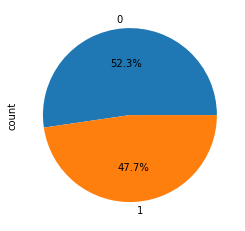

In [8]:
data['target'].value_counts().plot.pie(autopct = "%1.1f%%")

Fake: 52.3%, Real: 47.7%

### subject

subject EDA

<AxesSubplot:ylabel='count'>

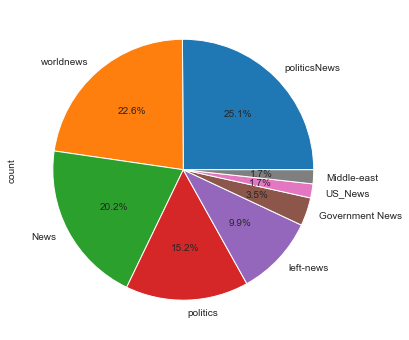

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize = (6, 6))
data['subject'].value_counts().plot.pie(autopct = "%1.1f%%")

politicsNews와 politics는 동일한 카테고리로 봐도 무방할 듯 
→ 하나의 카테고리 “PoliticsNews”로 합치기

<AxesSubplot:ylabel='count'>

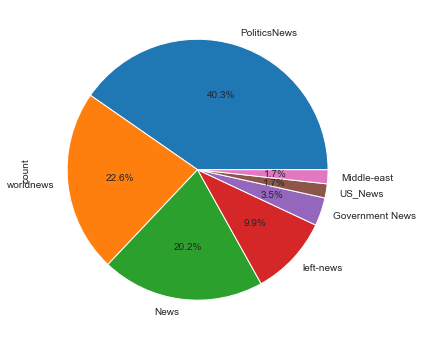

In [11]:
data["subject"]=data["subject"].replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})
sns.set_style("whitegrid")
plt.figure(figsize = (6, 6))
data['subject'].value_counts().plot.pie(autopct = "%1.1f%%")

- Fake News와 Real News의 주제 비율을 각각 알아보겠다.

Fake News Subject

In [12]:
rs1 = data[data['target'] == 0].groupby(['subject'], as_index = False).size()
rs1 = rs1.rename(columns = {"size": "count"}).sort_values(by = 'count', ascending = False)
print(rs1)

           subject  count
2             News   9050
3     PoliticsNews   6841
5        left-news   4459
0  Government News   1570
4          US_News    783
1      Middle-east    778


Text(0, 0.5, '')

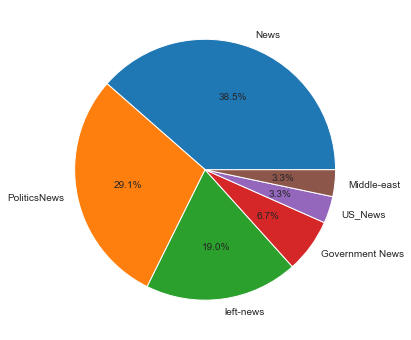

In [13]:
plt.figure(figsize = (6, 6))
data[data['target'] == 0]['subject'].value_counts().plot.pie(autopct = "%1.1f%%")
plt.ylabel(None)

1. News: 38.5%
2. PoliticsNews: 29.1%
3. left-news: 19.0%

Real News Subject

In [14]:
rs2 = data[data['target'] == 1].groupby(['subject'], as_index = False).size()
rs2 = rs2.rename(columns = {"size": "count"}).sort_values(by = 'count', ascending = False)
print(rs2)

        subject  count
0  PoliticsNews  11272
1     worldnews  10145


Text(0, 0.5, '')

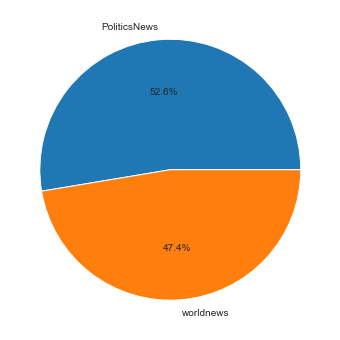

In [15]:
plt.figure(figsize = (6, 6))
data[data['target'] == 1]['subject'].value_counts().plot.pie(autopct = "%1.1f%%")
plt.ylabel(None)

1. PoliticsNews = 52.6%
2. worldnews = 47.4%

두 subject를 한번에 그리면 다음과 같은 막대 그래프가 나온다.

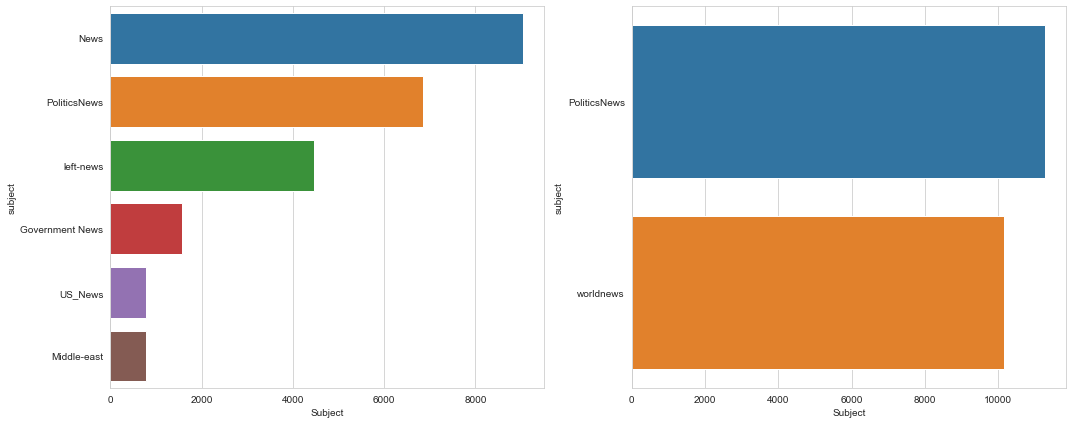

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))

# Fake news 
sns.barplot(ax = axs[0], x = 'count', y = 'subject', data = rs1)
axs[0].set_xlabel('Count')
axs[0].set_xlabel('Subject')

# Read news 
sns.barplot(ax = axs[1], x = 'count', y = 'subject', data = rs2)
axs[1].set_xlabel('Count')
axs[1].set_xlabel('Subject')

plt.tight_layout() # 여백 조정
plt.show()

"Subject" 는 모델을 overfitting하게 될 영향이 있음 → 제거 필요

### title

`\w+` : 한 개 이상의 알파벳 또는 숫자

`\s+` : 1개 이상의 공백 단위로 쪼개기

`r` : raw string → \를 탈출 문자로 보지않고 그냥 문자로 보겠다

`RegexpTokenizer` : 정규표현식을 넣어서 토큰화 진행 
→ `tokenizer.tokenize` 를 사용해서 token단위로 분해

In [17]:
print(data["title"])

0         BREAKING: GOP Chairman Grassley Has Had Enoug...
1         Failed GOP Candidates Remembered In Hilarious...
2         Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3        California AG pledges to defend birth control ...
4        AZ RANCHERS Living On US-Mexico Border Destroy...
                               ...                        
44893    Nigeria says U.S. agrees delayed $593 million ...
44894                    Boiler Room #62 – Fatal Illusions
44895    ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...
44896    Republican tax plan would deal financial hit t...
44897    U.N. refugee commissioner says Australia must ...
Name: title, Length: 44898, dtype: object


In [18]:
import nltk
df = pd.DataFrame()
def count_words(column):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(column)
    return new_words

df["n_words_in_title"] = data["title"].apply(count_words)
print(df["n_words_in_title"])

0        [BREAKING, GOP, Chairman, Grassley, Has, Had, ...
1        [Failed, GOP, Candidates, Remembered, In, Hila...
2        [Mike, Pence, s, New, DC, Neighbors, Are, HILA...
3        [California, AG, pledges, to, defend, birth, c...
4        [AZ, RANCHERS, Living, On, US, Mexico, Border,...
                               ...                        
44893    [Nigeria, says, U, S, agrees, delayed, 593, mi...
44894                 [Boiler, Room, 62, Fatal, Illusions]
44895    [ATHEISTS, SUE, GOVERNOR, OF, TEXAS, Over, Dis...
44896    [Republican, tax, plan, would, deal, financial...
44897    [U, N, refugee, commissioner, says, Australia,...
Name: n_words_in_title, Length: 44898, dtype: object


- tokenizer를 이용해서 문장을 word 단위로 쪼개었다.

- 각 title, text의 word를 계산해주는 함수이다.

In [19]:
import nltk
df = pd.DataFrame()
def count_words(column):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(column)
    return len(new_words)

df["n_words_in_title"]=data["title"].apply(count_words)
df["n_words_in_text"]=data["text"].apply(count_words)
df['target']=data['target']

<AxesSubplot:title={'center':'Number of words in the title'}, xlabel='target', ylabel='n_words_in_title'>

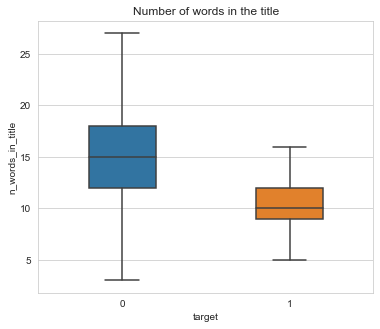

In [ ]:
fig = plt.figure(figsize = (6, 5))
plt.title("Number of words in the title")
sns.boxplot(data = df, x = 'target', y = 'n_words_in_title', showfliers = False, width = 0.4)

<AxesSubplot:title={'center':'Number of words in the text'}, xlabel='target', ylabel='n_words_in_text'>

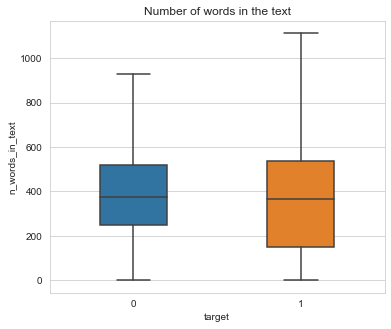

In [22]:
fig = plt.figure(figsize = (6, 5))
plt.title("Number of words in the text")
sns.boxplot(data = df, x = 'target', y = 'n_words_in_text', showfliers = False, width = 0.4)

text에 비해 title의 길이가 매우 작으므로 text와 title을 합쳐서 데이터 셋을 관리할 것이다.

### Summary

- `Shape = (44898, 5)`
- There is no missing values
- Fake: 52.3%, Real: 47.7% → 5:5
- `"title"` + `"text"` → `"text"` 로 사용
- `"date", "subject"` → 필요없음.

# Data preprocessing

## Preprocessing

In [23]:
data = data.drop(columns = ["date", "subject"])
data['text'] = data['title'] + " " + data['text']
data

,title,text,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,BREAKING: GOP Chairman Grassley Has Had Enoug...,0
1,Failed GOP Candidates Remembered In Hilarious...,Failed GOP Candidates Remembered In Hilarious...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,0
3,California AG pledges to defend birth control ...,California AG pledges to defend birth control ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,AZ RANCHERS Living On US-Mexico Border Destroy...,0
...,...,...,...
44893,Nigeria says U.S. agrees delayed $593 million ...,Nigeria says U.S. agrees delayed $593 million ...,1
44894,Boiler Room #62 – Fatal Illusions,Boiler Room #62 – Fatal Illusions Tune in to t...,0
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,0
44896,Republican tax plan would deal financial hit t...,Republican tax plan would deal financial hit t...,1


- title + text → text
- 나머지 필요없는 column들은 모두 제거

- `[]` : 한 개의 문자
- 대문자로 `W`를 쓰면 `\w`가 아닌 문자열만 선택
- `*` :0회 이상 반복
- `\\W` 의 의미

In [24]:
text = "I am @"
text = re.sub("\\W", " ", text)
text

'I am  '

### text preprocessing

1. 소문자로 변환
2. `.*?\` 문자 → text 제거
3. `\\W`:영어 x → 공백으로 변환
4. URL 제거
5. HTML 제거
6. 구두점 제거
7. 숫자가 포함된 문자 제거

In [26]:
import re  # Import the regular expressions module
import string  # Import the string module containing punctuation

def wordopt(text):
    # Convert the entire text to lowercase
    text = text.lower()

    # Remove text within square brackets, including the brackets
    text = re.sub('\[.*?\]', '', text)

    # Replace all non-alphabetic characters with a space
    text = re.sub("\\W", " ", text)

    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub('<.*?>', '', text)

    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)

    return text  # Return the preprocessed text

In [27]:
data['text'] = data['text'].apply(wordopt)
data['text']

0         breaking  gop chairman grassley has had enoug...
1         failed gop candidates remembered in hilarious...
2         mike pence s new dc neighbors are hilariously...
3        california ag pledges to defend birth control ...
4        az ranchers living on us mexico border destroy...
                               ...                        
44893    nigeria says u s  agrees delayed   million fig...
44894    boiler room     fatal illusions tune in to the...
44895    atheists sue governor of texas over display on...
44896    republican tax plan would deal financial hit t...
44897    u n  refugee commissioner says australia must ...
Name: text, Length: 44898, dtype: object

- 데이터 전처리 완료

### 의문점

- 숫자가 포함된 문자를 없애야 할까? → 돈, 방번호 등 꼭 제거되어야 하는 문자인가?
- stopword 제거는 언제 적용할 수 있을까?
- 이 데이터 셋이 가지는 패턴: True → “(Reuters)” / Fake → via #### Images(이미지 링크로 글이 끝남) 뉴스의 내용이 아니라 이러한 패턴으로 모델이 분류할 수 있지 않을까?

### Vectorization

- Shape = (44898, 5) → Train: 70%, Test: 30%

In [28]:
# train_test split
X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['target'], test_size = 0.3)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (31428,)
Y_train shape:  (31428,)
X_test shape:  (13470,)
Y_test shape:  (13470,)


### TfidfVectorizer

TfidfVectorizer: https://m.blog.naver.com/myincizor/221644893910

TF: 단어 빈도, IDF: 문서 빈도의 역수

In [29]:
vectorization = TfidfVectorizer()
cv_train = vectorization.fit(X_train)
cv_train.vocabulary_

{'gop': 32522,
 'senator': 73082,
 'has': 34797,
 'shockingly': 74277,
 'irresponsible': 40298,
 'response': 68563,
 'to': 82719,
 'news': 55685,
 'of': 57710,
 'russia': 70631,
 'election': 24586,
 'meddling': 50831,
 'tweet': 84703,
 'the': 81636,
 'washington': 88883,
 'post': 63078,
 'dropped': 23345,
 'bombshell': 9301,
 'intelligence': 39646,
 'revelation': 68848,
 'on': 58094,
 'us': 86746,
 'all': 2285,
 'friday': 30098,
 'wanted': 88724,
 'donald': 22721,
 'trump': 84102,
 'be': 7028,
 'president': 63712,
 'and': 3106,
 'they': 81924,
 'spent': 76951,
 'entire': 25527,
 'cycle': 18747,
 'doing': 22607,
 'could': 17450,
 'get': 31540,
 'him': 36091,
 'elected': 24583,
 'now': 56907,
 'no': 56364,
 'matter': 50143,
 'which': 89680,
 'candidate': 11916,
 'kremlin': 44699,
 'in': 38508,
 'office': 57754,
 'every': 26386,
 'american': 2804,
 'regardless': 67431,
 'political': 62650,
 'leanings': 45997,
 'should': 74401,
 'very': 87583,
 'alarmed': 1963,
 'that': 81609,
 'hostile': 

- TfidfVectorizer 를 통해서 어휘의 빈도수를 구해주고 각각의 단어에 대해 벡터를 만들어준다.

In [30]:
X_train,X_test,y_train,y_test = train_test_split(data['text'],data['target'],test_size=0.3)

vectorization = TfidfVectorizer()
cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)

Train shape:  (31428, 92977)
Test shape:  (13470, 92977)


In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


nb = MultinomialNB()
nb.fit(cv_train, y_train)
pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)

Accuracy Score:  0.9378619153674833


- 간단한 Multinomial Naive Bayes를 사용하여 정확도를 구했더니 93%정도가 나왔다.

### Preprocessing

기존 kaggle 코드에서 데이터 전처리 부분을 수정할 필요가 있다.

모델도 GPT로 변경하여 다시 진행해야겠다.

문맥 보존을 위해서 문단 전체를 Vectorize 하는 방법을 추천

**Fake news classification-BERT & RoBERTa:** 
https://www.kaggle.com/code/jaskaransingh/fake-news-classification-bert-roberta

In [32]:
sentences = data['text'].values
labels = data['target'].values

- text, target을 값만 복사해서 저장한다.

- 이미 훈련된 모델을 가져온다.

`BertForSequenceClassification.from_pretrained` :BERT model
`BertTokenizer.from_pretrained` : BERT Tokenizer → `[UNK]` token 사용

# Referance

Stopwords: https://wikidocs.net/22530

PortereStemmer: https://jaaamj.tistory.com/78

정규표현식: https://velog.io/@yoopark/r-prefix-in-regexp, https://blog.eomdev.com/java/2016/03/31/regExp.html

RegexpTokenizer: https://wikidocs.net/21703